In [1]:
# coding=utf-8
%matplotlib inline
from __future__ import division # En python2 le '/' c'est la divisione entière... cet import permet d'utiliser / "normalement"
import numpy as np  # on garde les import pour quand on etraiera le code source
import scipy as sci
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout  # bug in networkx 1.11 see : http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
import matplotlib.pyplot as plt
from nxpd import draw, nxpdParams
import pydot
import pandas as pd
import pygraphviz
import community as cmn
import igraph as ig

nxpdParams['show']= 'ipynb'



Couldn't import dot_parser, loading of dot files will not be possible.


# Different constructions of the line graph

In [2]:
def simple_line_graph(G=None):
    """ Construct the Simple line graph B^{\top} B"""
    
    if G is None:
        raise ValueError('Enter a graph please.')
    n_nodes = G.number_of_nodes()
    G.number_of_edges
    G_Incid = nx.incidence_matrix(G, weight='weight').todense() 
    
    C = np.transpose(G_Incid).dot(G_Incid)
    np.fill_diagonal(C, 0.)   # set all diagonal elts to 0
    
    L_G_C = nx.from_numpy_matrix(C) 
    return L_G_C

In [3]:
def weighted_line_graph(G=None):
    """ Construction of the weighted line graph of a graph G : B^{\top}(deg- I)^{pseudo-inv} B """
    
    n_nodes = G.number_of_nodes()
    G.number_of_edges
    G_Incid = nx.incidence_matrix(G, weight='weight').todense() 
    
    deg = np.diag(G.degree(weight='weight').values())
    L_Adj = G_Incid.T.dot(np.linalg.pinv(deg - np.eye(n_nodes))).dot(G_Incid)
    
    L_G_D = nx.from_numpy_matrix(L_Adj)
    return L_G_D

In [4]:
def normalized_weighted_line_graph(G=None):
    
    
    degree = np.array(G.degree().values())
    indices = degree > 1  # recup les indices de dgre >1 (en boolean indexing)
    
    n_nodes = G.number_of_nodes()
    taille = G.number_of_edges()

    B_tilde = nx.incidence_matrix(G, weight='weight').toarray().transpose()
    B=nx.incidence_matrix(G).toarray()
    A=np.array(nx.adjacency_matrix(G).toarray())
    
    
    degree = np.array(G.degree().values())
    indices = degree > 1  # recup les indices de dgre >1 (en boolean indexing)
    nodes_deg_sup_one = [key for key, val in G.degree().iteritems() if val > 1]
    
    S=np.sum(A, axis=1)
    
    E=np.zeros((taille,taille))
    for a in range(taille):
        for b in range(taille):
            if a!=b:
                E[a,b]=np.sum(np.divide(np.multiply(B_tilde[a, indices],B[indices,b]), S[indices]-B_tilde[b,indices]))
                
    H=nx.from_numpy_matrix(E,create_using=nx.MultiDiGraph())
    return H

In [5]:
def plot_graph(G=None, pos= None, weighted=False, col= 'orange', names=None, rescale=1.,arrows=False,linegraph=False,edge_col='black'):
    """ if the pos is None it will use the circular layout of NX, but you can pass pos as an argument.
    Can be useful, e.g. to compare the different constructions of the line graphs cause they have same nodes, but differ by
    the weights.
    Rescale is a parameter to rescale the weight in case they are too big and lead to too large edge width 
    """
    
    if G is None:
        raise ValueError('Enter a graph please.')
    
    if pos is None:
        pos=nx.circular_layout(G)
    
    if names is not None:
        nx.draw_networkx_labels(G,pos,labels=names,font_size_lab=2, alpha=0.5, font_family='sans-serif')
        
    if weighted:
        if linegraph:
            weights_ordered = [G.edge[i][j][0]['weight']/rescale for (i,j) in G.edges_iter()]
            nx.draw_circular(G, node_color=col, edge_color=edge_col, width=weights_ordered, with_labels = True,arrows=arrows)
        else:
            weights_ordered = [G.edge[i][j]['weight']/rescale for (i,j) in G.edges_iter()]
            nx.draw_circular(G, node_color=col, edge_color=edge_col, width=weights_ordered, with_labels = True,arrows=arrows)
    else:
        nx.draw_circular(G, node_color=col,edge_color=edge_col, with_labels = True,arrows=arrows)

    

## Toy examples

#### Simple and weighted line graphs of an unweighted graph

In [6]:
def create_connected_erdos(n_nodes, p=0.5, max_it=500):
    """ Create a networkx erdos-renyi connected graph
    inputs:
        -n_nodes : number of nodes for the random graphs 
        -p : parameter of the bernouilli
    returns:
        -G:  a nx connected graph with n_nodes nodes"""
    k=1
    while True: # try as long as it is not fully connected
        G=nx.erdos_renyi_graph(n_nodes, p)

        if nx.is_connected(G): 
            break  
        elif k > max_it:
            break
            print('Check value of p (might be too small) or try increasing the number of trials')

        k+=1
    return G

In [7]:
G = create_connected_erdos(10, 0.3)
n_nodes = G.number_of_nodes()
G.number_of_edges
G_Incid = nx.incidence_matrix(G, weight='weight').todense() 

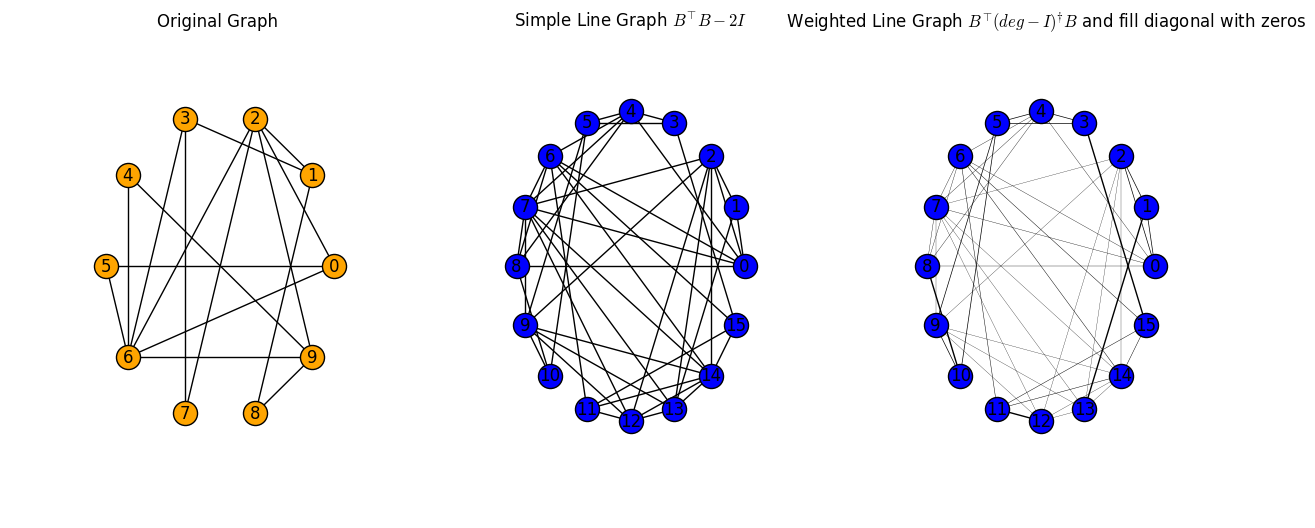

In [8]:
LG_simple = simple_line_graph(G)
LG_weighted = weighted_line_graph(G)

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(131)
plot_graph(G)
plt.title('Original Graph ')
pos=nx.circular_layout(LG_simple) # define a pos for both graph (same pos cuase same nodes)

ax2 = plt.subplot(132)
plot_graph(LG_simple, pos, col='blue')
plt.title('Simple Line Graph ' +  r'$B^{\top}B-2I$')

ax3 = plt.subplot(133)
plot_graph(LG_weighted, pos, weighted=True, col='blue')
plt.title('  Weighted Line Graph ' + r'$B^{\top}(deg-I)^{\dagger}B$ and fill diagonal with zeros')

#### Directed line graph of a weighted graph

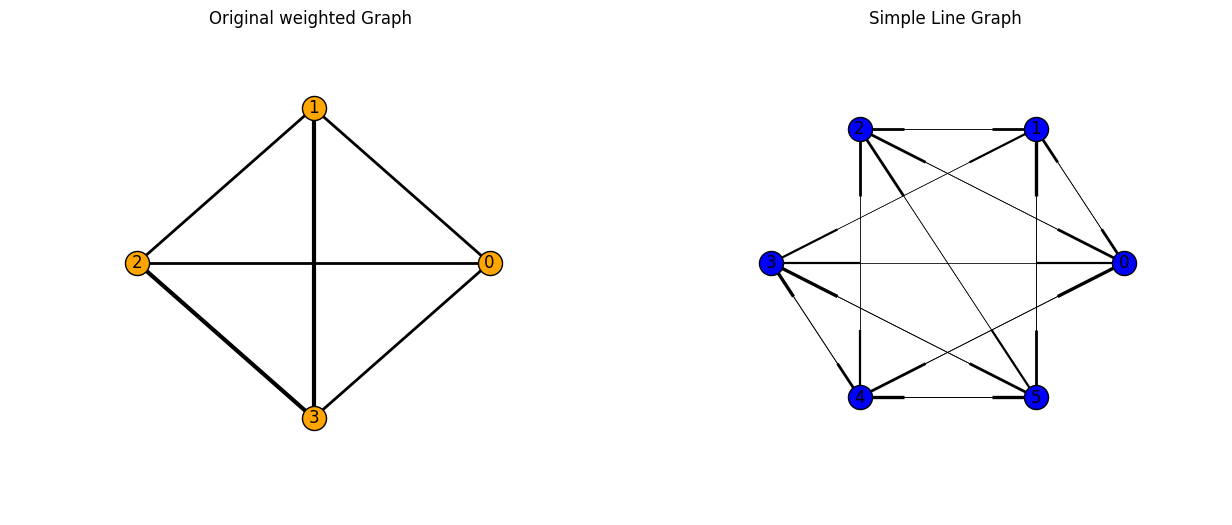

In [9]:
A=np.matrix([[np.random.randint(4) for i in range(4)] for j in range (4)])
for i in range(4):
    A[i,i]=0
    for j in range(4-i):
        A[i,i+j]=A[i+j,i]
G1=nx.from_numpy_matrix(A)
H1=normalized_weighted_line_graph(G1)

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
plot_graph(G1,col='orange', weighted=True)
plt.title('Original weighted Graph ')
pos=nx.circular_layout(LG_simple) # define a pos for both graph (same pos cuase same nodes)

ax2 = plt.subplot(122)
plot_graph(H1,col='blue', weighted=True,arrows=True,linegraph=True)
plt.title('Simple Line Graph ' )

# Application to Harry Potter

In [10]:
def shell_layout(G,nlist=None,dim=2,scale=1):
    """Position nodes in concentric circles, found on networkX documentation"""
    
    if len(G)==0:
        return {}
    if len(G)==1:
        return {G.nodes()[0]:(1,)*dim}
    if nlist==None:
        nlist=[G.nodes()] # draw the whole graph in one shell

    if len(nlist[0])==1:
        radius=0.0 # single node at center
    else:
        radius=1.0 # else start at r=1

    npos={}
    for nodes in nlist:
        t=np.arange(0,2.0*np.pi,2.0*np.pi/len(nodes),dtype=np.float32)
        pos=np.transpose(np.array([radius*np.cos(t),radius*np.sin(t)]))
        npos.update(zip(nodes,pos))
        radius+=1.0

    # FIXME: rescale
    return npos

In [11]:
hp_pandas=pd.read_excel("Cooccurences_HP1_final.xlsx")

nb_char=len(hp_pandas.index)
nb_pages=len(hp_pandas.columns)

hp=np.asarray(hp_pandas)

for i in range(nb_char):
    for j in range(nb_pages):
        if np.isnan(hp[i,j]):
            hp[i, j]=0
            
# counting coocurences in pages of the book
adj_hp=np.zeros((nb_char, nb_char))
for i in range(nb_char):
    for j in range(nb_char-i-1):
        for k in range(nb_pages):
            if(hp[i,k]+hp[i+j+1,k]==2):
                adj_hp[i,i+j+1]+=1
                adj_hp[i+j+1,i]+=1



G=nx.from_numpy_matrix(adj_hp)
names={}
for i in range(nb_char):
    names[i]=hp_pandas.index[i]
nb_edges=G.number_of_edges()

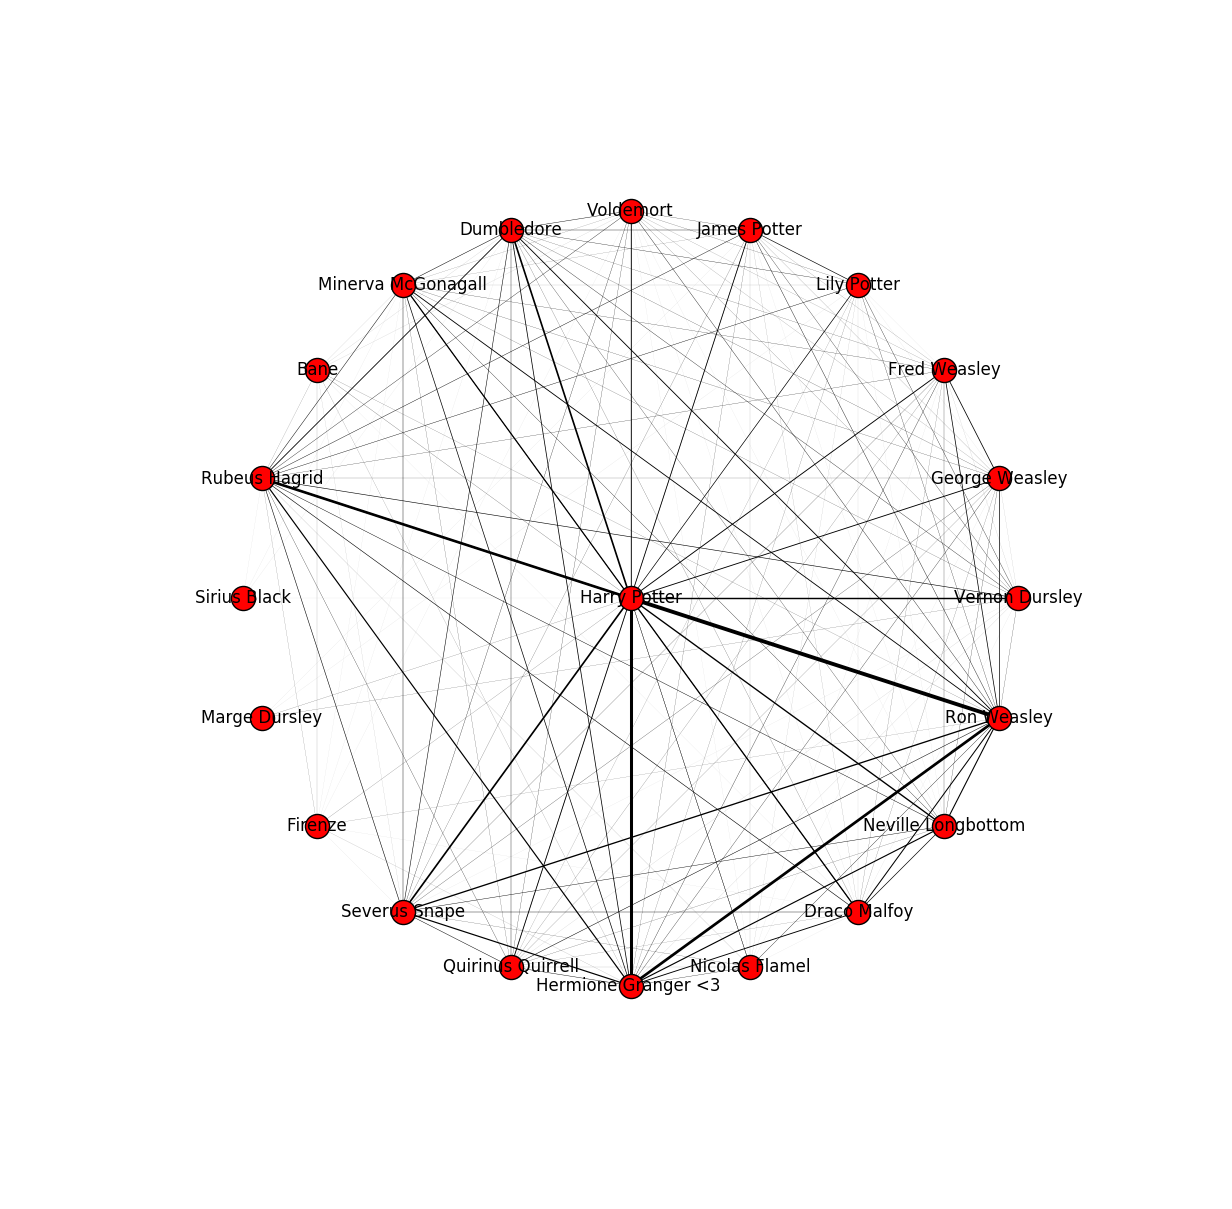

In [12]:
plt.figure(figsize=(15,15))

liste = list(G.nodes())
liste.remove(5)
shells=[[5], liste]
pos=nx.shell_layout(G,shells)

weights=[G[u][v]['weight']/50 for u,v in G.edges()]

nx.draw_networkx_labels(G,pos,labels=names,font_size_lab=2, alpha=0.5, font_family='sans-serif')  
nx.draw_networkx_edges(G, pos, width=weights, alpha=1, label=None) 
nx.draw_networkx_nodes(G, pos)
plt.axis('off')
#nx.draw(G, pos)
plt.show()

In [13]:
H=normalized_weighted_line_graph(G)

A=nx.adjacency_matrix(G)
tmp=np.zeros((nb_char,nb_char))
correspondance=np.zeros((nb_edges,2))
for index,val in enumerate(G.edges()):
    correspondance[index,0]=val[0]
    correspondance[index,1]=val[1]

H_undirected=nx.from_numpy_matrix(nx.adjacency_matrix(H.to_undirected()).todense())

In [14]:
partition = cmn.best_partition(H_undirected)

nb_com=len(set(partition.values()))

nodes_to_communities=np.zeros((nb_char,nb_com))
for j in range(nb_edges):
    nodes_to_communities[int(correspondance[j,0]),partition[j]]=1
    nodes_to_communities[int(correspondance[j,1]),partition[j]]=1
print partition

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 2, 8: 0, 9: 0, 10: 3, 11: 4, 12: 0, 13: 5, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 2, 22: 0, 23: 3, 24: 4, 25: 0, 26: 6, 27: 5, 28: 7, 29: 0, 30: 0, 31: 0, 32: 0, 33: 1, 34: 0, 35: 2, 36: 0, 37: 3, 38: 4, 39: 0, 40: 6, 41: 5, 42: 7, 43: 0, 44: 0, 45: 0, 46: 1, 47: 0, 48: 2, 49: 0, 50: 0, 51: 3, 52: 4, 53: 0, 54: 6, 55: 5, 56: 7, 57: 0, 58: 0, 59: 1, 60: 0, 61: 2, 62: 0, 63: 0, 64: 3, 65: 4, 66: 0, 67: 6, 68: 5, 69: 7, 70: 0, 71: 1, 72: 0, 73: 2, 74: 8, 75: 0, 76: 9, 77: 0, 78: 8, 79: 3, 80: 4, 81: 0, 82: 6, 83: 5, 84: 7, 85: 0, 86: 1, 87: 2, 88: 8, 89: 1, 90: 8, 91: 1, 92: 4, 93: 1, 94: 6, 95: 5, 96: 7, 97: 1, 98: 2, 99: 8, 100: 0, 101: 9, 102: 8, 103: 3, 104: 4, 105: 0, 106: 6, 107: 5, 108: 7, 109: 0, 110: 8, 111: 2, 112: 9, 113: 8, 114: 2, 115: 4, 116: 2, 117: 5, 118: 7, 119: 2, 120: 8, 121: 8, 122: 8, 123: 8, 124: 5, 125: 7, 126: 8, 127: 9, 128: 8, 129: 3, 130: 4, 131: 0, 132: 6, 133: 5, 134: 7, 135: 0, 136: 8, 137: 8, 138: 

In [15]:
"""printing communities"""

for com in range(nb_com):
    print([names[i] for i in np.argwhere(nodes_to_communities[:,com]==1).flatten()])
    print('\n')

[u'Vernon Dursley', u'George Weasley', u'Fred Weasley', u'Lily Potter', u'James Potter', u'Harry Potter', u'Dumbledore', u'Rubeus Hagrid', u'Marge Dursley', u'Hermione Granger <3 ', u'Ron Weasley']


[u'Vernon Dursley', u'George Weasley', u'Fred Weasley', u'Lily Potter', u'James Potter', u'Harry Potter', u'Voldemort', u'Dumbledore', u'Rubeus Hagrid', u'Severus Snape', u'Hermione Granger <3 ', u'Ron Weasley']


[u'Vernon Dursley', u'George Weasley', u'Fred Weasley', u'Lily Potter', u'James Potter', u'Harry Potter', u'Voldemort', u'Dumbledore', u'Minerva McGonagall', u'Rubeus Hagrid', u'Severus Snape', u'Hermione Granger <3 ', u'Ron Weasley']


[u'Vernon Dursley', u'George Weasley', u'Fred Weasley', u'Lily Potter', u'James Potter', u'Harry Potter', u'Dumbledore', u'Rubeus Hagrid', u'Severus Snape', u'Hermione Granger <3 ', u'Ron Weasley']


[u'Vernon Dursley', u'George Weasley', u'Fred Weasley', u'Lily Potter', u'James Potter', u'Harry Potter', u'Voldemort', u'Dumbledore', u'Minerva McGo

In [16]:
"""creating a partition of the edges"""
partition_rekeyed = {(int(correspondance[key, 0]), int(correspondance[key,1])): val for key, val in partition.iteritems() }

## Plot of the relevant communities graph

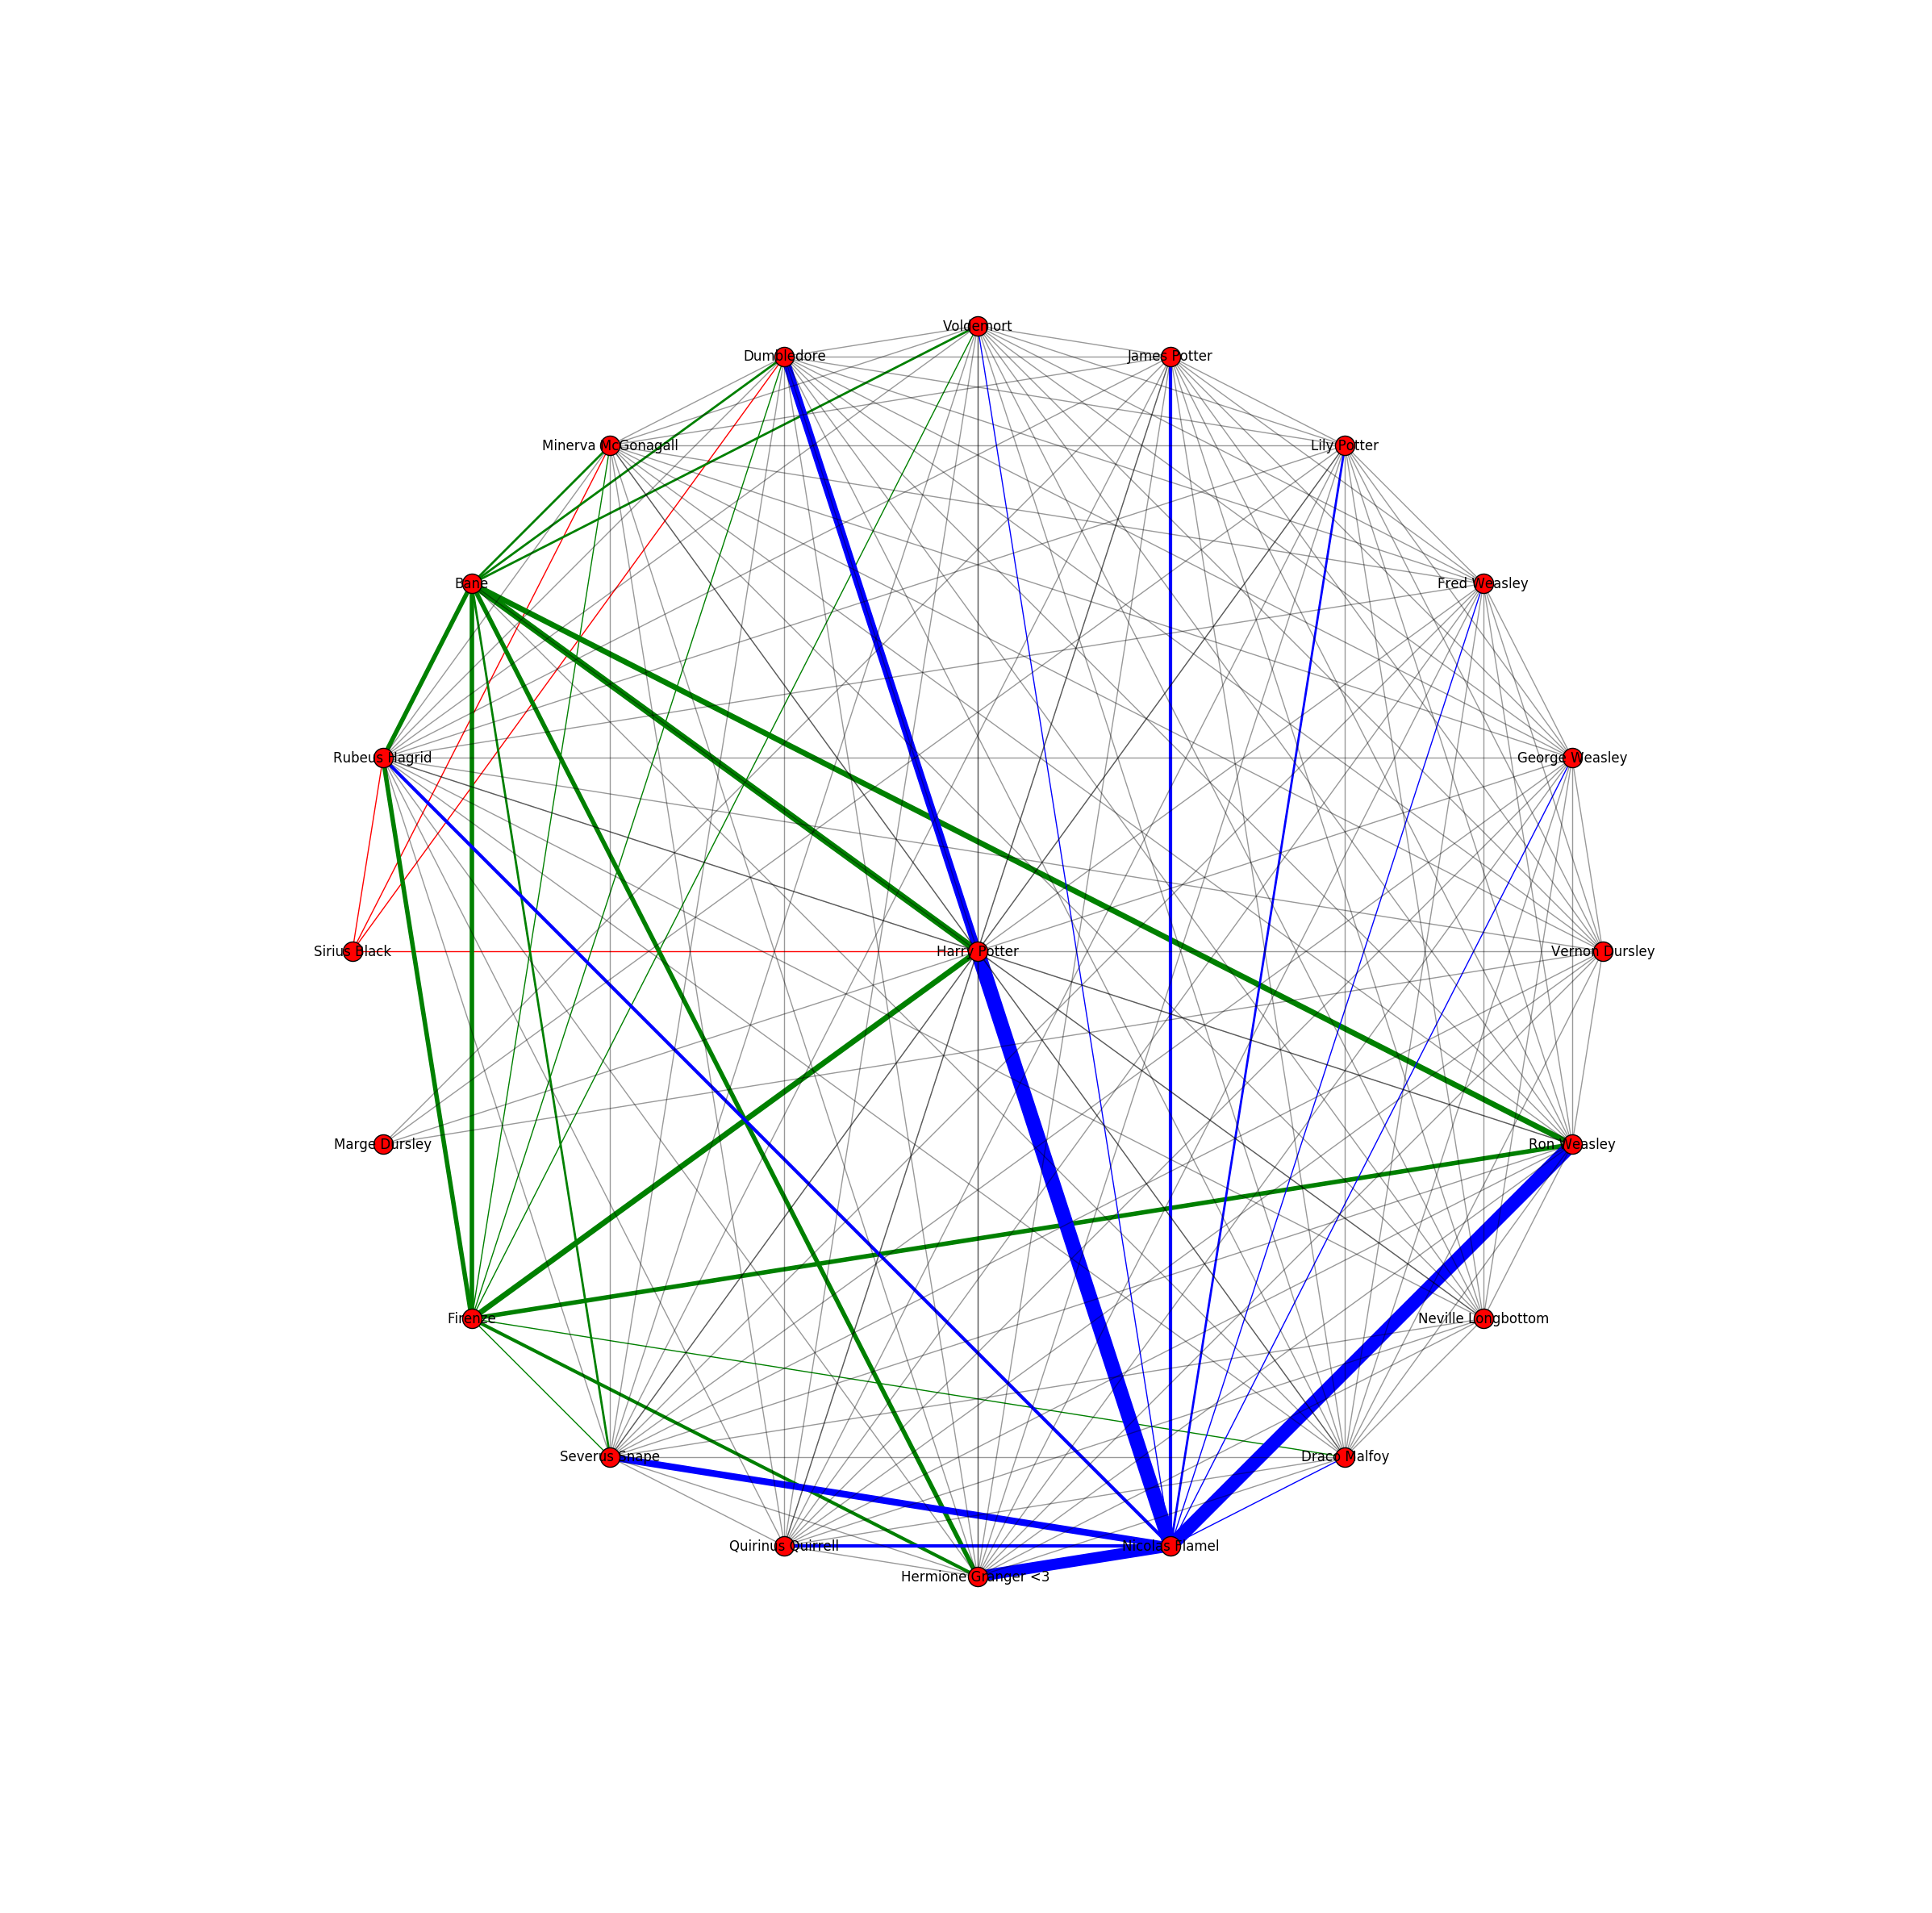

In [17]:
communities=np.transpose(nodes_to_communities)
liste = list(G.nodes())
liste.remove(5)
shells=[[5], liste]
pos=nx.shell_layout(G,shells)
list_of_edge = []

rescale= [1,1,1]
plt.figure(figsize=(30,30))
col = ['red', 'g', 'b']

temp = range(nb_com)

for g, i in enumerate([-1,-2,-4]):
    indices = np.argwhere(communities[i, :] == 1).flatten()

    sub = G.subgraph(indices)
    sub_edge_list = [e for e, com in partition_rekeyed.iteritems() if com == temp[i]]
    list_of_edge.extend(sub_edge_list)
    weights_ordered = [sub.edge[k][l]['weight']/rescale[g] for (k,l) in sub_edge_list]
    nx.draw_networkx_edges(G, pos, edgelist=sub_edge_list, width=weights_ordered, edge_color=col[g], alpha=1.0, label=None) 

remaining_edges = [edge for edge in G.edges() if edge not in list_of_edge]
nx.draw_networkx_labels(G,pos,labels=names,font_size_lab=2, alpha=0.5, font_family='sans-serif')  
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, width=1., alpha=0.4, label=None) 
nx.draw_networkx_nodes(G, pos)
plt.axis('off')
#nx.draw(G, pos)
plt.show()

plt.figure(figsize=(30,30))

## Plots of relevant communities

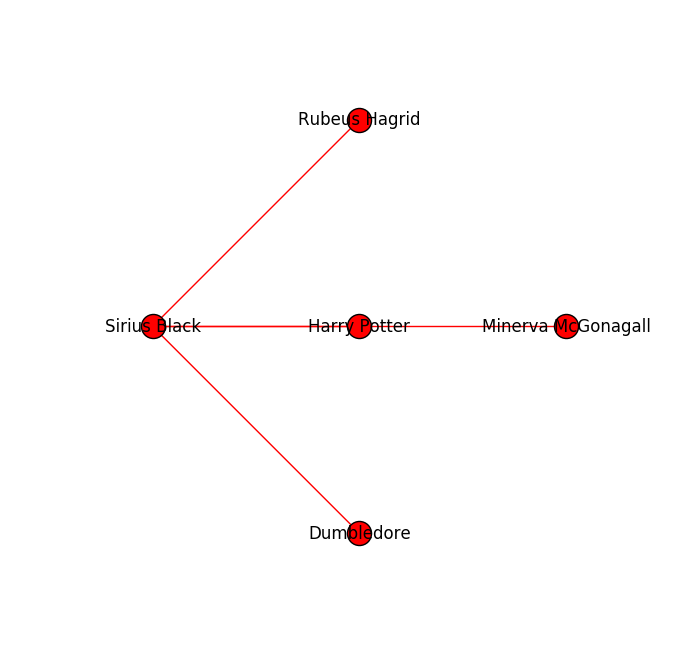

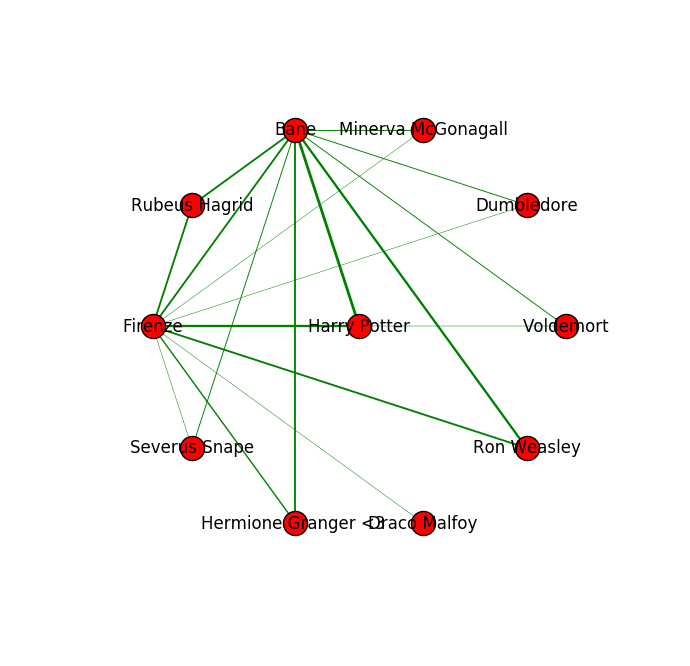

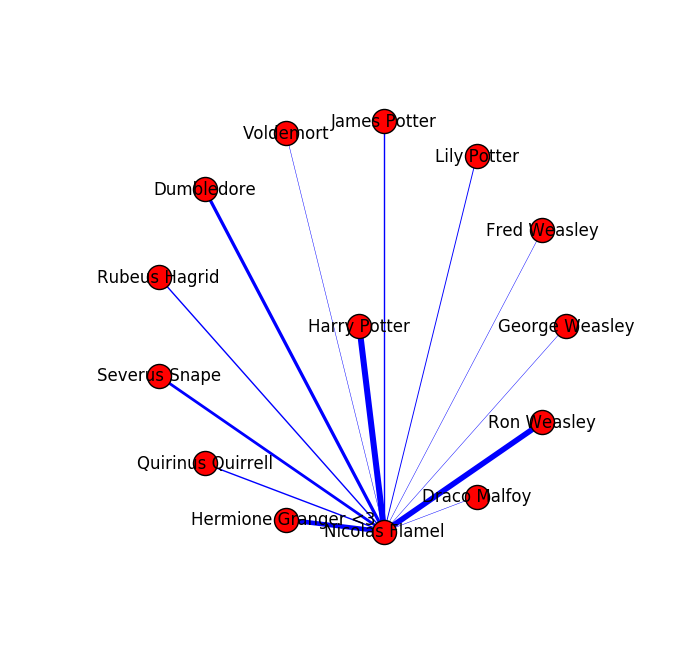

In [18]:
plt.figure(figsize=(20,20))
col = ['r', 'g', 'b']

indices = np.argwhere(communities[-1, :] == 1).flatten()
sub = G.subgraph(indices)
sub_names = {key:name for key, name in names.iteritems() if key in indices}

#fig = plt.figure(figsize=(15,15))
col = ['r', 'g', 'b']
rescale = [1,3,3]
for g, i in enumerate([-1,-2,-4]):
    
    fig = plt.figure(figsize=(8,8))

    indices = np.argwhere(communities[i, :] == 1).flatten()
    sub = G.subgraph(indices)
    sub_names = {key:name for key, name in names.iteritems() if key in indices}
    sub_edge_list = [e for e, com in partition_rekeyed.iteritems() if com == temp[i]]
    weights_ordered = [sub.edge[k][l]['weight']/rescale[g] for (k,l) in sub_edge_list]

    liste = list(sub.nodes())
    #plt.subplot(13(g+1))
    liste.remove(5)
    shells=[[5], liste]
    pos=nx.shell_layout(sub, shells)
    nx.draw_networkx_edges(G, pos, edgelist=sub_edge_list, width=weights_ordered, edge_color=col[g], alpha=1.0, label=None) 
    nx.draw_networkx_labels(sub,pos,labels=sub_names,font_size_lab=2, alpha=1, font_family='sans-serif')  
    nx.draw_networkx_nodes(sub, pos)
    plt.axis('off')
    plt.show()


# Our own algorithm 
(still working on convergence issues)

In [19]:
def is_stochastic(P, dec):
    """ check if a matrix is stochastic up to a certain decimal (controled by dec) precision"""
    return np.testing.assert_almost_equal(np.squeeze(np.asarray(np.sum(P, axis=1))), np.ones(P.shape[0], dtype=float), 
                                   decimal=dec)



def directed_transition_matrix(G, precision=15):
    """ Given a directed multigraph G, return the transition matrix : it will construct the transition with the
    out strenght matrix : P = S_out^-1 * A
    """
    
    
    
    Adj = nx.adjacency_matrix(G).toarray()
    Deg = np.array(G.out_degree(weight='weight').values())
    
    P = Adj / Deg[:,None]
    is_stochastic(P, dec=precision)

    return P

def power_method(mat, maxit):
    """
    Does maxit iterations of the power method
    on the matrix mat starting at ones().
    Returns an approximation of the largest
    eigenvector of the matrix mat.
    """
    result = np.ones(mat.shape[0])
    for i in xrange(maxit):
        result = mat.dot(result)
        result = result/np.linalg.norm(result)
        
    return result/np.linalg.norm(result, ord=1) # proba vector


In [20]:
def modularity(G, communities, pi):
    """ Compute the modularity defined page 5 of the article for an weighted directed graph (with E and s_beta_out)
    - inputs:
        
        G  : the graph
        communities : a dictionnary containing lists of the different communities
        pi : stationnary law for the graph G (non trivial for weighted directed graphs)
    
    -return :
        modularity : the modularity score for the partition community
    """
    
    E = nx.adjacency_matrix(G).toarray()
    S_out = np.array(G.out_degree(weight='weight').values())
    
    modularity = 0
    for com in communities.values():
        modularity += np.sum(np.multiply(np.divide(E[np.ix_(com, com)], S_out[com, None]),  pi[com, None]) - pi[com, None].dot(pi[None, com])  )

    return modularity
    

In [21]:
def modularity_improvement(G, i, j, communities, node_to_community_map, pi):
    """Function that calculates the variation of modularity by moving i from its community to the one of its neighbor j"""
    
    E = nx.adjacency_matrix(G).toarray().transpose()
    S_out = np.array(G.out_degree(weight='weight').values())

    C_old = communities[node_to_community_map[i]]
    C_new = communities[node_to_community_map[j]]
        
    if C_old == []:
        raise ValueError('C_old est vide')
    elif C_new == []:
        raise ValueError('C_new est vide')
    
    
    delta=0
    delta = (pi[i]/S_out[i]) * ( np.sum(E[C_new,i]) - np.sum(E[C_old,i]))
    
    delta += np.sum(np.multiply(np.divide(E[i,C_new], S_out[C_new]), pi[C_new])) - np.sum(np.multiply(np.divide(E[i,C_old], S_out[C_old]), pi[C_old]))
    delta += 2*pi[i]*(np.sum(pi[C_old]) - np.sum(pi[C_new]))
    delta += -2*pow(pi[i],2)
    if C_old == C_new:
        print 'C_old==C_new but delta=', delta
    return delta

In [22]:
def Louvain_partition(G):
    """ Louvain methodcconsists in two pass repeated iteratively.

    """

    #######################################
    ############ initialisation ################
    ###################################


    
    tol = 1e-8
    G = G.copy()
    dict_of_dict_solution = {} # a dictionnary that will contain the dict 'communities' at each pass (pass==phase (1)+(2))

    n_pass = 0
    dict_of_dict_solution[n_pass] = {num_community: [node]  for num_community, node in enumerate(G.nodes())} #initialize with the trivial partition
    Stop =False

    while (n_pass < 1) and (not Stop):  # n_pass <1 to force to only one pass yet, because still in debugging
        
        ###########################################################################"
        ###################" First phase(repeated) : local modularity optima #################"
        #########################################################################"
        P = directed_transition_matrix(G)
        pi = power_method(P.T, 1500)  #left eigenvalue of P <=> right eigenvalue of P^T
        
        node_to_community_map = G.nodes()  #a list containing the number of the community of each node (like HW3 of GinML)
        communities = {num_community: [node]  for num_community, node in enumerate(G.nodes()) } #each node is in its own community

        n_iterations =0
        has_improved=1
        
        modularity_new = modularity(G, communities, pi) #all node in it's own community --> Q = 0
        
        while has_improved and (n_iterations < 10):
            
            node_to_community_map_old = list(node_to_community_map) #copy and stock the old map for breakout condition

            n_iterations +=1
            has_improved = False #breakout condition
            
            node_copy = list(G.nodes()) #copy a list because if liste1 = liste2 then modif liste2 --> modif liste1 !
            
            np.random.shuffle(node_copy)  #suffle les nodes
            for i in node_copy:
                neighbors_of_i = [  j for j in nx.neighbors(G, i) if (node_to_community_map[i] != node_to_community_map[j])  ]
                delta = np.zeros(len(neighbors_of_i))
                
                if neighbors_of_i != []: # i.e. if i have neighbors that are not in the same community as 'him'
                    
                    # ensure that the neighbors visited belongs to different communities, we don't want to compute 
                    # the same quantity more than necessary
                    restricted_neighbors_of_i = []
                    liste_of_community = []
                    for neighb in neighbors_of_i:
                        if node_to_community_map[neighb] not in liste_of_community:
                            restricted_neighbors_of_i.append(neighb)
                            liste_of_community.append(node_to_community_map[neighb])
                        
                        
                    for idx, j in enumerate(restricted_neighbors_of_i):  # calculate the update in modularity
                        delta[idx] = modularity_improvement(G, i, j, communities, node_to_community_map, pi) 
                    #print 'size of delta',len(delta)
                    max_improvement = np.max(delta)  

                    if max_improvement > tol:
                        #don't use np.argmax which only return first indice, we want the full list
                        ind = np.argwhere(delta == max_improvement).flatten() 
                        
                        #check if there's no tie and solve them with random selection
                        if len(ind) > 1:
                            ind = np.random.choice(ind) #select a random node unifrmly

                        best_neighbor = neighbors_of_i[ind]
                        

                        
                        #actualize communities and node_to_community_map
                        communities[node_to_community_map[best_neighbor]].append(i)
                        communities[node_to_community_map[i]].remove(i)
    
                        node_to_community_map[i] = node_to_community_map[best_neighbor]
        
                        #calculate new modularity
                        
                        modularity_old = modularity_new   
                        modularity_new = modularity(G, communities, pi )
                        
                        test = modularity_new - modularity_old
                        if modularity_new < modularity_old:
                            print 'pb modularity is increasing, max_improvement =', max_improvement
                            print 'mod_old', modularity_old
                            print 'mod_new', modularity_new
                           
                        #   raise ValueError('Test != max_improvement')
                    
                    
                        #print 'communities = ', communities
                        #print 'node_to_comm_map = ', node_to_community_map
                        #print 'modularity improve !', modularity_new
                        #print 'delta Q =', max_improvement
            
            if node_to_community_map != node_to_community_map_old:
                has_improved= True  #we have improved at this iteration --> we continue to iterate (see the condition in while)
                print 'we  improved at iteartion : ', n_iterations
                
            #print node_to_community_map
                    
            
            
        #print communities
        print n_iterations  
        
        ##### After first phase we can have some [] (empty lists) in the dictionnary 'communities' : we delete them #######
        communities = { key : liste for key, liste in communities.iteritems() if liste}
        
        modularity_new = modularity(G, communities, pi )
        #print 'modularity at the end of', n_pass, 'pass is at', modularity_new
        
        n_pass += 1
        dict_of_dict_solution[n_pass] = communities #store the new partition given by first phase
        
        print 'n_pass=', n_pass
        ####stopping condition for the overall machinery : 
        # If we didn't change anything in the communities since last pass then no improvement is possible anymore and Louvain stop

        if dict_of_dict_solution[n_pass] == dict_of_dict_solution[n_pass-1]:
            Stop = True
        elif len(dict_of_dict_solution[n_pass]) == 1: # i.e. only one community
            Stop =True
        
        

        ####################################################################################################
        # Second phase of Louvain : collapsing the graph by merging communities in one 'super-node'###################
        ####################################################################################################

        ######## create the adjacency matrix of the new graph ############"

        E = nx.adjacency_matrix(G).toarray()
        new_nb_of_nodes = len(communities) # number of communities <=> nb of nodes in the new graph
        E_new = np.zeros((new_nb_of_nodes, new_nb_of_nodes))

        for i, key_i in enumerate(communities.keys()):
            for j, key_j in enumerate(communities.keys()):
                E_new[i, j] = np.sum(E[np.ix_(communities[key_i], communities[key_j])]) ## Why np.ix_ ? : http://stackoverflow.com/questions/30176268/error-when-indexing-with-2-dimensions-in-numpy

        G=nx.from_numpy_matrix(E_new, create_using=nx.MultiDiGraph())

    
    return dict_of_dict_solution, node_to_community_map


        
                
    


In [23]:
partition_HP, node_to_community_map_HP = Louvain_partition(H)

D:\Program Files (x86)\Anaconda3\envs\python2_7\lib\site-packages\ipykernel\__main__.py:75: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


pb modularity is increasing, max_improvement = 0.0144703511892
mod_old 0.183010392448
mod_new 0.181644218447
pb modularity is increasing, max_improvement = 0.00164041349601
mod_old 0.239975245501
mod_new 0.239886280233
pb modularity is increasing, max_improvement = 0.00336516136099
mod_old 0.278781556571
mod_new 0.278648326117
pb modularity is increasing, max_improvement = 0.00056333857847
mod_old 0.301870635823
mod_new 0.300940926935
pb modularity is increasing, max_improvement = 0.0100449240433
mod_old 0.301503644303
mod_new 0.299826066768
pb modularity is increasing, max_improvement = 0.0469777593629
mod_old 0.300058375158
mod_new 0.298900264216
pb modularity is increasing, max_improvement = 0.00191460120583
mod_old 0.306468760034
mod_new 0.305862388045
we  improved at iteartion :  1
pb modularity is increasing, max_improvement = 0.00834264232306
mod_old 0.313402175615
mod_new 0.312509920611
pb modularity is increasing, max_improvement = 0.00177260410381
mod_old 0.320574613753
mod_n

KeyboardInterrupt: 

In [ ]:
nb_com=len(set(partition.values()))

nodes_to_communities=np.zeros((nb_char,nb_com))
for j in range(nb_edges):
    nodes_to_communities[int(correspondance[j,0]),partition[j]]=1
    nodes_to_communities[int(correspondance[j,1]),partition[j]]=1

In [ ]:
partition_HP[1]
good_numerotation = list(set(node_to_community_map_HP))
print good_numerotation

print node_to_community_map_HP
partition = {node:good_numerotation.index(com) for node, com in enumerate(node_to_community_map_HP) }
print partition




In [ ]:
nb_com=len(set(partition.values()))

nodes_to_communities=np.zeros((nb_char,nb_com))
for j in range(nb_edges):
    nodes_to_communities[int(correspondance[j,0]),partition[j]]=1
    nodes_to_communities[int(correspondance[j,1]),partition[j]]=1
print partition

print nb_com

In [ ]:
"""printing communities"""

for com in range(nb_com):
    print([names[i] for i in np.argwhere(nodes_to_communities[:,com]==1).flatten()])
    print('\n')